Start by downloading and opening a real image from PTF (https://ui.adsabs.harvard.edu/abs/2009PASP..121.1395L/abstract)

In [1]:
import os
from astropy.io import fits
im_path = 'data'
im_link = ''
im_filename = 'PTF_20100216_075004_11_R_Diff_B74YFO_u-r4yk3x.image.fits'

with fits.open(os.path.join(im_path, im_filename)) as hdu:
    im = hdu[0].data

flags_filename = 'PTF_20100216_075004_11_R_Diff_B74YFO_u-r4yk3x.flags.fits'
with fits.open(os.path.join(im_path, flags_filename)) as hdu:
    flags = hdu[0].data

(4096, 2048)


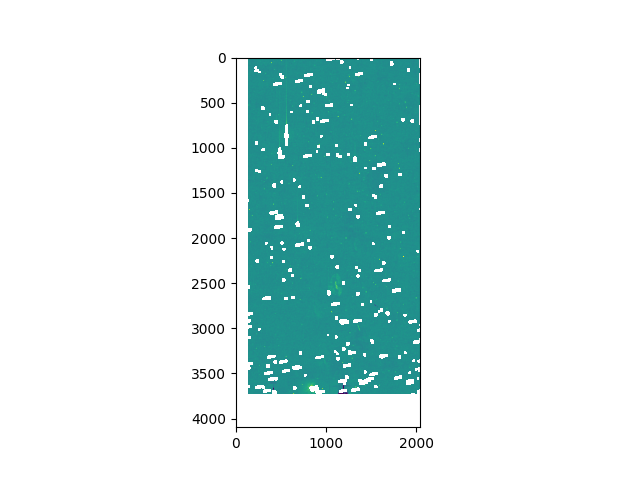

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

im_path = 'data'
im_filename = 'PTF_20100216_075004_11_R_Diff_B74YFO_u-r4yk3x.image.fits'
with fits.open(os.path.join(im_path, im_filename)) as hdu:
    im = hdu[0].data

flags_filename = 'PTF_20100216_075004_11_R_Diff_B74YFO_u-r4yk3x.flags.fits'
with fits.open(os.path.join(im_path, flags_filename)) as hdu:
    flags = hdu[0].data

imnan = im.copy()
imnan[flags>0] = np.nan;
print(im.shape)
plt.figure()
plt.imshow(imnan, vmin=-5, vmax=5)

To make this run a lot faster we can cut a 1024x1024 square around a place we already see has a streak. 
The finder can do something similar by making sections internally using `use_sections`. This will just speed things up. 

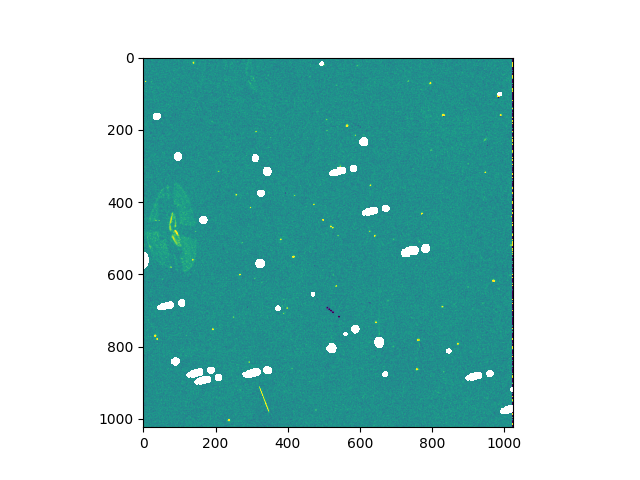

In [3]:
section = imnan[2048:3072, 1024:2048]
plt.figure()
plt.imshow(section, vmin=-5, vmax=5)

In [13]:
import time
from src.finder import Finder
t0 = time.perf_counter()
f = Finder(verbosity=10, use_show=False, threshold=7.5, use_exclude=False)
f.input(section)
t1 = time.perf_counter() - t0
print(f"Streak finding took {t1:.2f}s")

mx= 225.59 | dynamic_range= 4.91e+00 | thresholds: [240.  120.   60.   30.   15.    7.5]
Running FRT 1 times, transpose= False, thresh= 240.00, found streak: False
Running FRT 2 times, transpose= True, thresh= 240.00, found streak: False
Running FRT 3 times, transpose= False, thresh= 120.00, found streak: False
Running FRT 4 times, transpose= True, thresh= 120.00, found streak: False
Running FRT 5 times, transpose= False, thresh= 60.00, found streak: True
Running FRT 6 times, transpose= False, thresh= 60.00, found streak: False
Running FRT 7 times, transpose= True, thresh= 60.00, found streak: False
Running FRT 8 times, transpose= False, thresh= 30.00, found streak: False
Running FRT 9 times, transpose= True, thresh= 30.00, found streak: False
Running FRT 10 times, transpose= False, thresh= 15.00, found streak: True
Running FRT 11 times, transpose= False, thresh= 15.00, found streak: False
Running FRT 12 times, transpose= True, thresh= 15.00, found streak: True
Running FRT 13 times, tr

The first streak that was detected is the very bright and obvious satellite trail on the bottom of the section. 
This is an easy target for streak detection, but much fainter streaks can also be found. 
Note that because of the way the image is sliced into powers of 2, the streak tracks do not match 
the streak start/end points exactly. Additional fitting of the streak cutout (using the initial fit) is recommended. 

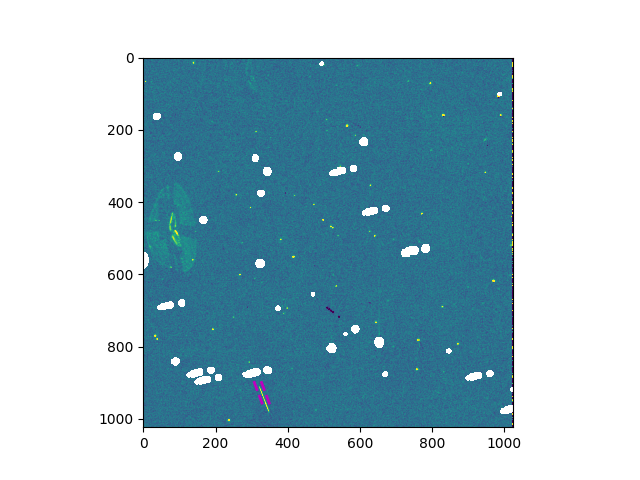

In [6]:
plt.figure(); f.streaks[0].show(vmin=-3, vmax=5)

The remaining streaks that were detected are false positives. 
Mostly they are due to the weird "ghost" artefact on the left-hand side of the image. 
There's also a long streak on the right-hand side that seems to be just triggering on 
noise and maybe the bright edges of the image. 
Real images must apply additional filtering of the streaks that were detected. 
The FRT algorithm can detect faint streaks, but has no mechanism for removing splotches 
or even just random false alarms. This is especially true if the background is not uniform
or if the noise RMS is higher than what was given to the `Finder`. 

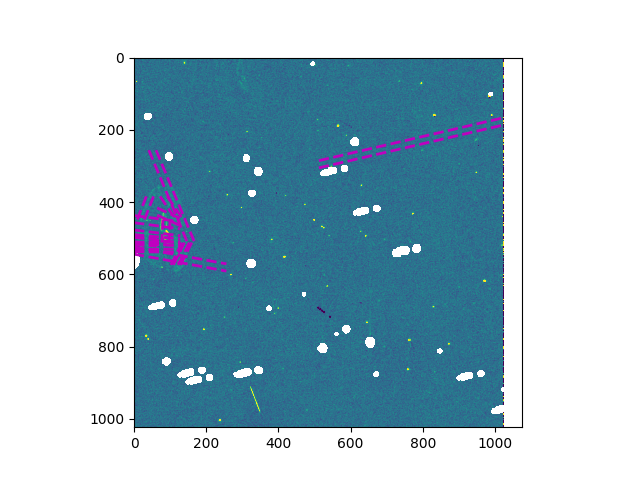

In [11]:
plt.figure() 
for i in range(1, len(f.streaks)):
    f.streaks[i].show(vmin=-3, vmax=5)
    

Try to add lots of white noise to this image. The bright satellite trail is now much fainter.  

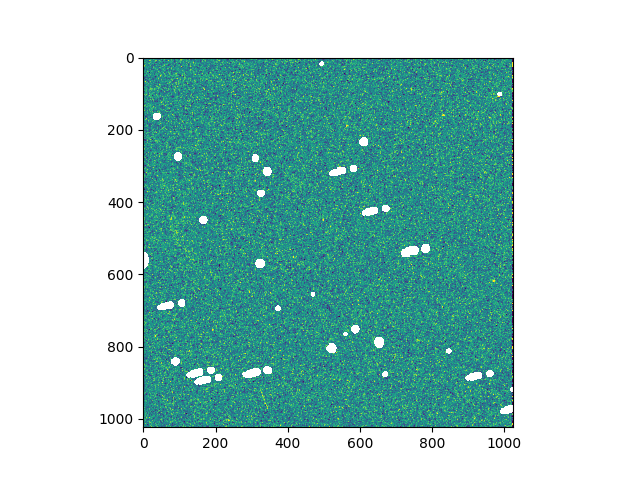

In [52]:
sigma = 10
section2 = section + np.random.normal(0, sigma, size=section.shape)
sigma = np.sqrt(sigma ** 2 + np.nanvar(section))  # make sure to account for the real image variance
plt.figure()
plt.imshow(section2, vmin=-sigma, vmax=sigma)

In [53]:
f.input(section2, variance=sigma**2)
len(f.streaks)

mx= 21.73 | dynamic_range= 1.53e+00 | thresholds: [30.  15.   7.5]
Running FRT 1 times, transpose= False, thresh= 30.00, found streak: False
Running FRT 2 times, transpose= True, thresh= 30.00, found streak: False
Running FRT 3 times, transpose= False, thresh= 15.00, found streak: False
Running FRT 4 times, transpose= True, thresh= 15.00, found streak: False
Running FRT 5 times, transpose= False, thresh= 7.50, found streak: True
Running FRT 6 times, transpose= False, thresh= 7.50, found streak: False
Running FRT 7 times, transpose= True, thresh= 7.50, found streak: False


1

The streak is still detectable, only just above the threshold of 7.5 sigma

7.652513887725427

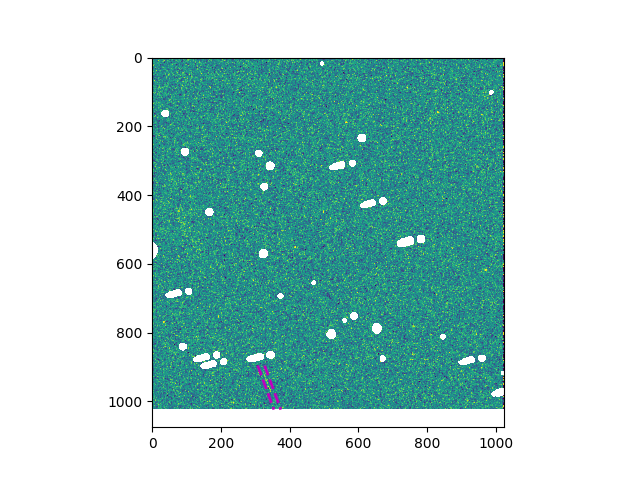

In [55]:
plt.figure(); f.streaks[0].show(vmin=-sigma, vmax=sigma)
f.streaks[0].snr